In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install warnings
!pip install dgl
!pip install texttable

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(device)

2.0.1+cu118
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 627.0/627.0 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.1/504.1 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.3/732.3 kB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.7/205.7 kB 20.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings
Looking in indexes: https://pypi.org/simple

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data
import scipy
import pickle
from skimage.segmentation import slic
from torchvision import datasets
import multiprocessing as mp
from torch_geometric.utils import from_networkx,to_networkx
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, BatchNorm, global_mean_pool
from torch_geometric.utils import softmax, degree

#/content/drive/MyDrive/Colab_Notebooks
import os
import random
import numpy as np
import os.path as osp
from torch.autograd import grad
from drive.MyDrive.Colab_Notebooks.DIR_GNN.utils.mask import set_masks, clear_masks
from drive.MyDrive.Colab_Notebooks.DIR_GNN.utils.logger import Logger
from datetime import datetime
from drive.MyDrive.Colab_Notebooks.DIR_GNN.utils.helper import random_partition, set_seed
from drive.MyDrive.Colab_Notebooks.DIR_GNN.utils.get_subgraph import split_graph, relabel
import scipy.ndimage
import scipy.spatial
import argparse
import datetime
import networkx as nx
import dgl
import os
import pickle
from scipy.spatial.distance import cdist
import numpy as np
import itertools

import csv
from sklearn.model_selection import StratifiedShuffleSplit
import random
from torchvision import transforms, datasets

import time

from scipy import ndimage



import torch


import matplotlib.pyplot as plt
import matplotlib

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [3]:

def sigma(dists, kth=8):
    # Get k-nearest neighbors for each node
    knns = np.partition(dists, kth, axis=-1)[:, kth::-1]

    # Compute sigma and reshape
    sigma = knns.sum(axis=1).reshape((knns.shape[0], 1))/kth
    return sigma + 1e-8 # adding epsilon to avoid zero value of sigma

def compute_adjacency_matrix_images(coord, feat, use_feat=False, kth=8):
    coord = coord.reshape(-1, 2)
    # Compute coordinate distance
    c_dist = cdist(coord, coord)

    if use_feat:
        # Compute feature distance
        f_dist = cdist(feat, feat)
        # Compute adjacency
        A = np.exp(- (c_dist/sigma(c_dist))**2 - (f_dist/sigma(f_dist))**2 )
    else:
        A = np.exp(- (c_dist/sigma(c_dist))**2)

    # Convert to symmetric matrix
    A = 0.5 * A * A.T
    A[np.diag_indices_from(A)] = 0
    return A

def compute_edges_list(A, kth=8+1):
    # Get k-similar neighbor indices for each node
    if 1==1:
        num_nodes = A.shape[0]
        new_kth = num_nodes - kth
        knns = np.argpartition(A, new_kth-1, axis=-1)[:, new_kth:-1]
        knns_d = np.partition(A, new_kth-1, axis=-1)[:, new_kth:-1]
    else:
        knns = np.argpartition(A, kth, axis=-1)[:, kth::-1]
        knns_d = np.partition(A, kth, axis=-1)[:, kth::-1]
    return knns, knns_d
class newCIFARSuperPix(torch.utils.data.Dataset):
    def __init__(self,
                 data_dir,
                 use_mean_px=True,
                 use_coord=True,
                 use_feat_for_graph_construct=False,):

        #self.split = split
        #self.is_test = split.lower() in ['test', 'val']
        with open(data_dir, 'rb') as f:
            self.labels, self.sp_data = pickle.load(f)

        self.use_mean_px = use_mean_px
        self.use_feat_for_graph = use_feat_for_graph_construct
        self.use_coord = use_coord
        self.n_samples = len(self.labels)
        self.img_size = 32

    def precompute_graph_images(self):
        #print('precompute all data for the %s set...' % self.split.upper())
        self.Adj_matrices, self.node_features, self.edges_lists = [], [], []
        for index, sample in enumerate(self.sp_data):
            mean_px, coord = sample[:2]
            coord = coord / self.img_size
            A = compute_adjacency_matrix_images(coord, mean_px, use_feat=self.use_feat_for_graph)
            edges_list, _ = compute_edges_list(A)
            N_nodes = A.shape[0]

            x = None
            if self.use_mean_px:
                x = mean_px.reshape(N_nodes, -1)
            if self.use_coord:
                coord = coord.reshape(N_nodes, 2)
                if self.use_mean_px:
                    x = np.concatenate((x, coord), axis=1)
                else:
                    x = coord
            if x is None:
                x = np.ones(N_nodes, 1)  # dummy features

            self.node_features.append(x)
            self.Adj_matrices.append(A)
            self.edges_lists.append(edges_list)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        g = dgl.DGLGraph()
        g.add_nodes(self.node_features[index].shape[0])
        g.ndata['feat'] = torch.Tensor(self.node_features[index])
        for src, dsts in enumerate(self.edges_lists[index]):
            g.add_edges(src, dsts[dsts!=src])

        return g, self.labels[index]

#use_feat_for_graph_construct = True
tt = time.time()
#data_with_feat_knn = newCIFARSuperPix("/content/drive/MyDrive/CMINST_data/CMNIST08_60000_75sp_train.pkl",use_feat_for_graph_construct=use_feat_for_graph_construct)

#data_with_feat_knn.precompute_graph_images()
#training_data = np.load('/content/drive/MyDrive/CMINST_data/colorMNIST08_60000_data.npy')
#training_label=np.load('/content/drive/MyDrive/CMINST_data/colorMNIST08_60000_label.npy')

In [4]:
#https://github.com/Wuyxin/DIR-GNN/blob/09b5c94b2c42e12802ebed9f672fb519b101f8ad/datasets/mnistsp_dataset.py
import numpy as np
import os.path as osp
import pickle
import torch
import torch.utils
import torch.utils.data
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import InMemoryDataset,Data
#/content/drive/MyDrive/Colab_Notebooks/mnist08_83_75sp_train.pkl
def compute_adjacency_matrix_images(coord, sigma=0.1):
    coord = coord.reshape(-1, 2)
    dist = cdist(coord, coord)
    A = np.exp(- dist / (sigma * np.pi) ** 2)
    A[np.diag_indices_from(A)] = 0
    return A


def list_to_torch(data):
    for i in range(len(data)):
        if data[i] is None:
            continue
        elif isinstance(data[i], np.ndarray):
            if data[i].dtype == np.bool:
                data[i] = data[i].astype(np.float32)
            data[i] = torch.from_numpy(data[i]).float()
        elif isinstance(data[i], list):
            data[i] = list_to_torch(data[i])
    return data
def process(data_file):
  use_mean_px=True
  use_coord=True
  node_gt_att_threshold=0
  transform=None
  pre_transform=None
  pre_filter=None

  #data_file ='/content/drive/MyDrive/Colab_Notebooks/mm012305_75sp_train.pkl'
  with open(osp.join(data_file), 'rb') as f:
      labels,sp_data = pickle.load(f)

  use_mean_px = use_mean_px
  use_coord = use_coord
  n_samples = len(labels)
  img_size = 32
  #node_gt_att_threshold = self.node_gt_att_threshold

  edge_indices,xs,edge_attrs,node_gt_atts,edge_gt_atts = [], [], [], [], []
  data_list = []
  for index, sample in enumerate(sp_data):
      mean_px, coord = sample[:2]
      coord = coord / img_size
      A = compute_adjacency_matrix_images(coord)
      N_nodes = A.shape[0]

      A = torch.FloatTensor((A > 0.1) * A)
      edge_index, edge_attr = dense_to_sparse(A)

      x = None
      if use_mean_px:
          x = mean_px.reshape(N_nodes, -1)
      if use_coord:
          coord = coord.reshape(N_nodes, 2)
          if use_mean_px:
              x = np.concatenate((x, coord), axis=1)
          else:
              x = coord
      if x is None:
          x = np.ones(N_nodes, 1)  # dummy features

      # replicate features to make it possible to test on colored images
      x = np.pad(x, ((0, 0), (2, 0)), 'edge')
      if node_gt_att_threshold == 0:
          node_gt_att = (mean_px > 0).astype(np.float32)
      else:
          node_gt_att = mean_px.copy()
          node_gt_att[node_gt_att < node_gt_att_threshold] = 0

      node_gt_att = torch.LongTensor(node_gt_att).view(-1)
      row, col = edge_index
      edge_gt_att = torch.LongTensor(node_gt_att[row] * node_gt_att[col]).view(-1)

      data_list.append(
          Data(
              x=torch.tensor(x),
              y=torch.LongTensor([labels[index]]),
              edge_index=edge_index,
              edge_attr=edge_attr,
              node_gt_att=node_gt_att,
              edge_gt_att=edge_gt_att

          )
      )

  #torch.save(InMemoryDataset.collate(data_list), '/content/drive/MyDrive/Colab_Notebooks/mm012305.pt')
  return data_list

In [18]:
train_dir='/content/drive/MyDrive/CMINST_data/CMNIST095_10000_75sp_train.pkl'
val_dir='/content/drive/MyDrive/CMINST_data/CMNIST5000_75sp_val.pkl'
test_dir='/content/drive/MyDrive/CMINST_data/CMNIST10000_75sp_test.pkl'
training_final=process(data_file=train_dir)
valing_final=process(data_file=val_dir)
testing_final=process(data_file=test_dir)

In [6]:
import os.path as osp

import torch
import torch.nn as nn
from torch.nn import ModuleList
import torch.nn.functional as F
from torch.nn import Sequential as Seq, ReLU, Tanh, Linear as Lin, Softmax
from torch_geometric.nn import GraphConv, BatchNorm, global_max_pool,LEConv, BatchNorm, fps

class MNISTSPNet(torch.nn.Module):

    def __init__(self, in_channels, hid_channels=32, num_classes=10, conv_unit=2):
        super(MNISTSPNet, self).__init__()

        self.node_emb = Lin(in_channels, hid_channels)

        self.convs = ModuleList()
        self.batch_norms = ModuleList()
        self.relus = ModuleList()

        for i in range(conv_unit):
            conv = GraphConv(in_channels=hid_channels, out_channels=hid_channels)
            self.convs.append(conv)
            self.batch_norms.append(BatchNorm(hid_channels))
            self.relus.append(ReLU())

        self.causal_mlp = nn.Sequential(
            nn.Linear(hid_channels, 2*hid_channels),
            nn.ReLU(),
            nn.Linear(2*hid_channels, num_classes)
        )

        self.conf_mlp = torch.nn.Sequential(
            nn.Linear(hid_channels, 2*hid_channels),
            ReLU(),
            nn.Linear(2*hid_channels, num_classes)
        )

    def forward(self, x, edge_index, edge_attr, batch):
        node_x = self.get_node_reps(x, edge_index, edge_attr, batch)
        graph_x = global_max_pool(node_x, batch)
        return self.get_causal_pred(graph_x)

    def get_node_reps(self, x, edge_index, edge_attr, batch):
        edge_weight = edge_attr.view(-1)
        x = self.node_emb(x)
        for conv, batch_norm, ReLU in \
                zip(self.convs, self.batch_norms, self.relus):
            x = conv(x, edge_index, edge_weight=edge_weight)
            x = ReLU(batch_norm(x))
        node_x = x
        return node_x

    def get_graph_rep(self, x, edge_index, edge_attr, batch):

        node_x = self.get_node_reps(x, edge_index, edge_attr, batch)
        graph_x = global_max_pool(node_x, batch)
        return graph_x

    def get_causal_pred(self, causal_graph_x):
        pred = self.causal_mlp(causal_graph_x)
        return pred

    def get_conf_pred(self, conf_graph_x):
        pred = self.conf_mlp(conf_graph_x)
        return pred

    def get_comb_pred(self, causal_graph_x, conf_graph_x):
        causal_pred = self.causal_mlp(causal_graph_x)
        conf_pred = self.conf_mlp(conf_graph_x).detach()
        return torch.sigmoid(conf_pred)*causal_pred

In [13]:
class CausalAttNet(nn.Module):

    def __init__(self, causal_ratio,out_channels):
        super(CausalAttNet, self).__init__()
        self.conv1 = GraphConv(in_channels=7,out_channels=out_channels)
        self.conv2 = GraphConv(in_channels=out_channels, out_channels=out_channels)
        self.mlp = nn.Sequential(
            nn.Linear(out_channels*2, out_channels*4),
            nn.ReLU(),
            nn.Linear(out_channels*4, 1)
        )
        self.ratio = causal_ratio
    def forward(self, data):
        x = F.relu(self.conv1(data.x.to(torch.float32), data.edge_index, data.edge_attr.view(-1)))
        x = self.conv2(x, data.edge_index, data.edge_attr.view(-1))

        row, col = data.edge_index
        edge_rep = torch.cat([x[row], x[col]], dim=-1)
        edge_score = self.mlp(edge_rep).view(-1)

        (causal_edge_index, causal_edge_attr, causal_edge_weight), \
        (conf_edge_index, conf_edge_attr, conf_edge_weight) = split_graph(data,edge_score, self.ratio)

        causal_x, causal_edge_index, causal_batch, _ = relabel(x, causal_edge_index, data.batch)
        conf_x, conf_edge_index, conf_batch, _ = relabel(x, conf_edge_index, data.batch)

        return (causal_x, causal_edge_index, causal_edge_attr, causal_edge_weight, causal_batch),\
                (conf_x, conf_edge_index, conf_edge_attr, conf_edge_weight, conf_batch),\
                edge_score
        #return x,causal_edge_index,conf_edge_index

In [ ]:
#len(new_012)

In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
#Epoch=2
#alpha_prime = 1e-4 * (Epoch ** 1.6)
causal_ratio=0.8
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
g = MNISTSPNet(32).to(device)
att_net = CausalAttNet(causal_ratio,32).to(device)
model_optimizer = torch.optim.Adam(
            list(g.parameters()) +
            list(att_net.parameters()),
            lr=0.001)
conf_opt = torch.optim.Adam(g.conf_mlp.parameters(), lr=0.001)
CELoss = nn.CrossEntropyLoss(reduction="mean")
train_loader = DataLoader(training_final, batch_size=32, shuffle=True)
val_loader = DataLoader(valing_final, batch_size=32, shuffle=False)
test_loader = DataLoader(testing_final, batch_size=128, shuffle=False)
EXp=500
import gc
del training_final
del valing_final
gc.collect()

0

In [ ]:
use_feat_for_graph_construct = False
#tt = time.time()
data_with_feat_knn = newCIFARSuperPix('/content/drive/MyDrive/CMINST_data/CMNIST10000_75sp_test.pkl',use_feat_for_graph_construct=use_feat_for_graph_construct)

data_with_feat_knn.precompute_graph_images()

testing_data = np.load('/content/drive/MyDrive/CMINST_data/colorMNIST10000_test_data.npy')
testing_label=np.load('/content/drive/MyDrive/CMINST_data/colorMNIST10000_test_label.npy')


In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/running_dir_mnist/allmodel_DIR_095.pt')
att_net = CausalAttNet(causal_ratio,32).to(device)
att_net.load_state_dict(checkpoint['causal_model'])
test_loader = DataLoader(testing_final, batch_size=1, shuffle=False)
#predictco_model.load_state_dict(checkpoint['predictco_model_state_dict()'])

In [ ]:
t=[]
for i in test_loader:
  t.append(i)

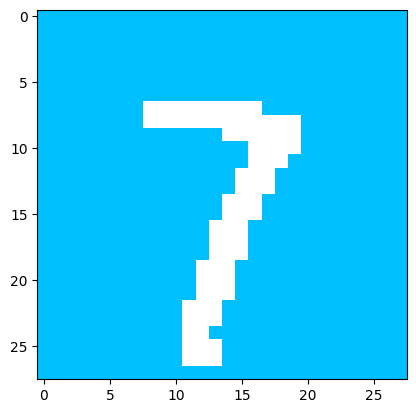

Label:  7


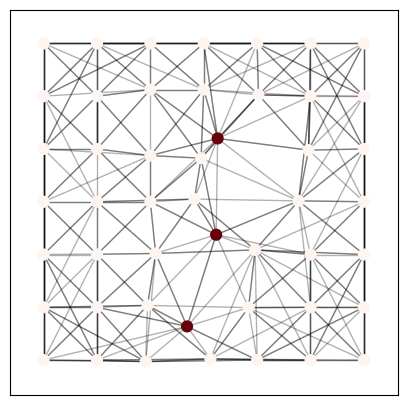

In [ ]:
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from pylab import rcParams
idex=87
plt.imshow(testing_data[idex])
plt.show()
print("Label: ",testing_label[idex])
sp_data=data_with_feat_knn.sp_data[idex]
adj_matrix=data_with_feat_knn.Adj_matrices[idex]
label=data_with_feat_knn[idex][1]
feat_coord=data_with_feat_knn.use_feat_for_graph
#causal_node=l
with_edges=True
plt.figure(figsize=(5, 5))
real=False

Y = squareform(pdist(sp_data[1], 'euclidean'))
x_coord = sp_data[1] #np.flip(dataset.train.sp_data[_][1], 1)
intensities = sp_data[0].mean(axis=1)
#intensities=np.array([0]*sp_data[0].shape[0])
#0, 29,  3, 43, 27, 39, 19, 36, 42
#intensities[[ 0, 29, 42,21, 24, 18,11,20,28,33,40,41,9,7,2]]=1
G = nx.from_numpy_array(Y)
pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
rotated_pos = {node: (y,-x) for (node, (x,y)) in pos.items()} # rotate the coords by 90 degree

edge_list = []
for src, dsts in enumerate(compute_edges_list(adj_matrix)[0]):
    for dst in dsts:
        edge_list.append((src, dst))

nx.draw_networkx_nodes(G, rotated_pos, node_color=intensities, cmap=matplotlib.cm.Reds, node_size=60) #len(intensities))
if with_edges:
    nx.draw_networkx_edges(G, rotated_pos, edge_list, alpha=0.3)

In [ ]:
att_net.eval()
x,cind,nocind = att_net(t[idex])

In [ ]:
torch.unique(cind)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66])

In [ ]:
dir=torch.topk(abs(x.sum(axis=1)),4)[1].tolist()

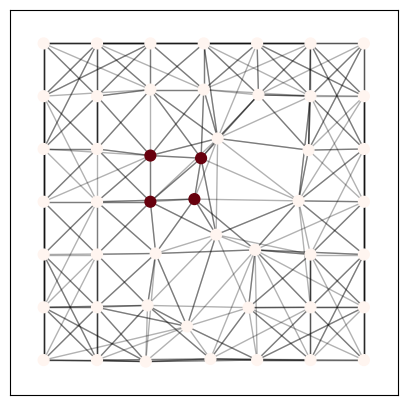

In [ ]:
plt.figure(figsize=(5, 5))
Y = squareform(pdist(sp_data[1], 'euclidean'))
x_coord = sp_data[1] #np.flip(dataset.train.sp_data[_][1], 1)
#intensities = abs(x.sum(axis=1)).view(-1).detach().numpy()
intensities=np.array([0]*sp_data[0].shape[0])
#[39, 19, 36, 37, 27, 43, 41,  3, 42, 29]
intensities[dir]=1
G = nx.from_numpy_array(Y)
pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
rotated_pos = {node: (y,-x) for (node, (x,y)) in pos.items()} # rotate the coords by 90 degree

edge_list = []
for src, dsts in enumerate(compute_edges_list(adj_matrix)[0]):
    for dst in dsts:
        edge_list.append((src, dst))

nx.draw_networkx_nodes(G, rotated_pos, node_color=intensities, cmap=matplotlib.cm.Reds, node_size=60) #len(intensities))
if with_edges:
    nx.draw_networkx_edges(G, rotated_pos, edge_list, alpha=0.3)

In [20]:
import time
import json

loss_value=[]
loss_value_valation=[]
from tqdm import tqdm
for epoch in range(EXp):
  g.train()
  att_net.train()
  all_loss, n_bw, all_env_loss = 0, 0, 0
  all_causal_loss, all_conf_loss = 0, 0
  causal_edge_weights = torch.tensor([]).to(device)
  conf_edge_weights = torch.tensor([]).to(device)
  alpha_prime = 1e-4 * (epoch ** 1.6)
  dummy_w = nn.Parameter(torch.Tensor([1.0])).to(device)
  print(f"-----training-------{epoch}")
  loop = tqdm(enumerate(train_loader),total=len(train_loader))
  for it, graph in loop:
      graph.to(device)
      n_bw += 1
      N = graph.num_graphs
      (causal_x, causal_edge_index, causal_edge_attr, causal_edge_weight, causal_batch),\
      (conf_x, conf_edge_index, conf_edge_attr, conf_edge_weight, conf_batch), edge_score = att_net(graph)

      set_masks(causal_edge_weight, g)
      causal_rep = g.get_graph_rep(x=causal_x, edge_index=causal_edge_index,edge_attr=causal_edge_attr, batch=causal_batch)
      causal_out = g.get_causal_pred(causal_rep)
      #print(causal_out)
      clear_masks(g)
      set_masks(conf_edge_weight, g)
      conf_rep = g.get_graph_rep(
          x=conf_x, edge_index=conf_edge_index,
          edge_attr=conf_edge_attr, batch=conf_batch).detach()
      conf_out = g.get_conf_pred(conf_rep)
      clear_masks(g)
      #y=to01(graph.y).to(device)
      #print(conf_out)
      causal_loss = CELoss(causal_out,graph.y)
      #print(causal_loss)

      uniform_target = torch.ones_like(causal_out, dtype=torch.float).to(device) / 4
      conf_loss = CELoss(conf_out,uniform_target)
      #print('noncausal',float(conf_loss))
      #all_conf_loss += conf_loss
      #all_causal_loss += causal_loss
      #all_env_loss += env_loss
      #print(all_causal_loss)
      env_loss = 0


      env_loss = torch.tensor([]).to(device)
      for conf in conf_rep:
          rep_out = g.get_comb_pred(causal_rep, conf)
          env_loss = torch.cat([env_loss, CELoss(rep_out, graph.y).unsqueeze(0)])
      causal_loss += min(alpha_prime, 1) * env_loss.mean()
      env_loss = alpha_prime * torch.var(env_loss * conf_rep.size(0))

      all_conf_loss += conf_loss
      all_causal_loss += causal_loss
      all_env_loss += env_loss
      causal_edge_weights = torch.cat([causal_edge_weights, causal_edge_weight])
      conf_edge_weights = torch.cat([conf_edge_weights, conf_edge_weight])

  all_env_loss /= n_bw
  all_causal_loss /= n_bw
  all_conf_loss /= n_bw
  all_loss = all_causal_loss + all_env_loss

  loss_value.append(all_loss.item())
  print(f'number of {epoch} of all loss:{all_loss}')
  conf_opt.zero_grad()
  all_conf_loss.backward()
  conf_opt.step()

  model_optimizer.zero_grad()
  all_loss.backward()
  model_optimizer.step()

  with torch.no_grad():
    g.eval()
    att_net.eval()
    acc = 0
    for graph in val_loader:
        graph.to(device)
        (causal_x, causal_edge_index, causal_edge_attr, causal_edge_weight, causal_batch),\
        (conf_x, conf_edge_index, conf_edge_attr, conf_edge_weight, conf_batch), edge_score = att_net(graph)
        set_masks(causal_edge_weight, g)
        out = g(x=causal_x, edge_index=causal_edge_index,
                edge_attr=causal_edge_attr, batch=causal_batch)
        clear_masks(g)
        acc += torch.sum(out.argmax(-1).view(-1) == graph.y.view(-1))
    acc = float(acc) / len(val_loader.dataset)
    loss_value_valation.append(acc)
    print(f"causal val accuracy:{acc}")
    dictionary={"number of epoch":epoch,
                "training loss list":loss_value,
                "valation accuracy list":loss_value_valation}

    # Serializing json
    json_object = json.dumps(dictionary,indent=3)

    # Writing to sample.json
    with open("/content/drive/MyDrive/running_dir_mnist/numberDIR_tl_va_e08.json", "w") as outfile:
        outfile.write(json_object)

    torch.save({
            'causal_model': att_net.state_dict(),
            'predictco': g.state_dict(),
            'model_optimizer':model_optimizer.state_dict(),
            'conf_opt':conf_opt.state_dict()
            }, '/content/drive/MyDrive/running_dir_mnist/allmodel_DIR_08.pt')
    if(epoch>50):
      check=abs(acc-loss_value_valation[len(loss_value_valation)-20])/20
      if(check<=0.01):
        break








''' conf_opt.zero_grad()
all_conf_loss.backward()
conf_opt.step()

model_optimizer.zero_grad()
all_loss.backward()
model_optimizer.step()'''





-----training-------0


100%|██████████| 313/313 [00:18<00:00, 16.73it/s]


number of 0 of all loss:2.432300329208374
causal val accuracy:0.103
-----training-------1


100%|██████████| 313/313 [00:18<00:00, 17.15it/s]


number of 1 of all loss:2.3207643032073975
causal val accuracy:0.0996
-----training-------2


100%|██████████| 313/313 [00:18<00:00, 17.04it/s]


number of 2 of all loss:2.232469320297241
causal val accuracy:0.0986
-----training-------3


100%|██████████| 313/313 [00:18<00:00, 17.08it/s]


number of 3 of all loss:2.1568071842193604
causal val accuracy:0.095
-----training-------4


100%|██████████| 313/313 [00:17<00:00, 17.58it/s]


number of 4 of all loss:2.0893847942352295
causal val accuracy:0.0993
-----training-------5


100%|██████████| 313/313 [00:17<00:00, 17.60it/s]


number of 5 of all loss:2.027571678161621
causal val accuracy:0.1012
-----training-------6


100%|██████████| 313/313 [00:18<00:00, 17.32it/s]


number of 6 of all loss:1.969882607460022
causal val accuracy:0.1007
-----training-------7


100%|██████████| 313/313 [00:17<00:00, 17.60it/s]


number of 7 of all loss:1.9175193309783936
causal val accuracy:0.0994
-----training-------8


100%|██████████| 313/313 [00:17<00:00, 17.39it/s]


number of 8 of all loss:1.8633947372436523
causal val accuracy:0.1
-----training-------9


100%|██████████| 313/313 [00:18<00:00, 17.29it/s]


number of 9 of all loss:1.8146027326583862
causal val accuracy:0.1002
-----training-------10


100%|██████████| 313/313 [00:17<00:00, 17.41it/s]


number of 10 of all loss:1.7658424377441406
causal val accuracy:0.0995
-----training-------11


100%|██████████| 313/313 [00:18<00:00, 17.09it/s]


number of 11 of all loss:1.7199825048446655
causal val accuracy:0.0907
-----training-------12


100%|██████████| 313/313 [00:18<00:00, 17.15it/s]


number of 12 of all loss:1.6764769554138184
causal val accuracy:0.0901
-----training-------13


100%|██████████| 313/313 [00:18<00:00, 16.90it/s]


number of 13 of all loss:1.633326768875122
causal val accuracy:0.0935
-----training-------14


100%|██████████| 313/313 [00:18<00:00, 16.74it/s]


number of 14 of all loss:1.5865962505340576
causal val accuracy:0.0939
-----training-------15


100%|██████████| 313/313 [00:18<00:00, 16.65it/s]


number of 15 of all loss:1.5451438426971436
causal val accuracy:0.1016
-----training-------16


100%|██████████| 313/313 [00:18<00:00, 16.90it/s]


number of 16 of all loss:1.5061143636703491
causal val accuracy:0.0906
-----training-------17


100%|██████████| 313/313 [00:17<00:00, 17.66it/s]


number of 17 of all loss:1.4702725410461426
causal val accuracy:0.0938
-----training-------18


100%|██████████| 313/313 [00:17<00:00, 17.41it/s]


number of 18 of all loss:1.4299633502960205
causal val accuracy:0.0971
-----training-------19


100%|██████████| 313/313 [00:18<00:00, 16.48it/s]


number of 19 of all loss:1.3920735120773315
causal val accuracy:0.1033
-----training-------20


100%|██████████| 313/313 [00:19<00:00, 16.13it/s]


number of 20 of all loss:1.3505128622055054
causal val accuracy:0.1052
-----training-------21


100%|██████████| 313/313 [00:19<00:00, 15.96it/s]


number of 21 of all loss:1.31722092628479
causal val accuracy:0.1022
-----training-------22


100%|██████████| 313/313 [00:18<00:00, 16.72it/s]


number of 22 of all loss:1.279106616973877
causal val accuracy:0.1019
-----training-------23


100%|██████████| 313/313 [00:18<00:00, 16.86it/s]


number of 23 of all loss:1.2413179874420166
causal val accuracy:0.1044
-----training-------24


100%|██████████| 313/313 [00:18<00:00, 16.65it/s]


number of 24 of all loss:1.2039563655853271
causal val accuracy:0.1028
-----training-------25


100%|██████████| 313/313 [00:18<00:00, 16.81it/s]


number of 25 of all loss:1.1681748628616333
causal val accuracy:0.1025
-----training-------26


100%|██████████| 313/313 [00:18<00:00, 16.92it/s]


number of 26 of all loss:1.134472131729126
causal val accuracy:0.1044
-----training-------27


100%|██████████| 313/313 [00:19<00:00, 16.05it/s]


number of 27 of all loss:1.0984665155410767
causal val accuracy:0.1008
-----training-------28


100%|██████████| 313/313 [00:18<00:00, 16.90it/s]


number of 28 of all loss:1.0659593343734741
causal val accuracy:0.1031
-----training-------29


100%|██████████| 313/313 [00:17<00:00, 17.67it/s]


number of 29 of all loss:1.029322862625122
causal val accuracy:0.098
-----training-------30


100%|██████████| 313/313 [00:17<00:00, 17.62it/s]


number of 30 of all loss:0.9947834014892578
causal val accuracy:0.1005
-----training-------31


100%|██████████| 313/313 [00:18<00:00, 17.22it/s]


number of 31 of all loss:0.9652756452560425
causal val accuracy:0.1013
-----training-------32


100%|██████████| 313/313 [00:17<00:00, 17.79it/s]


number of 32 of all loss:0.9355013966560364
causal val accuracy:0.1027
-----training-------33


100%|██████████| 313/313 [00:18<00:00, 17.11it/s]


number of 33 of all loss:0.8983755707740784
causal val accuracy:0.1003
-----training-------34


100%|██████████| 313/313 [00:18<00:00, 16.59it/s]


number of 34 of all loss:0.8664821982383728
causal val accuracy:0.1011
-----training-------35


100%|██████████| 313/313 [00:17<00:00, 17.39it/s]


number of 35 of all loss:0.8411431908607483
causal val accuracy:0.0967
-----training-------36


100%|██████████| 313/313 [00:18<00:00, 17.35it/s]


number of 36 of all loss:0.8121439814567566
causal val accuracy:0.0984
-----training-------37


100%|██████████| 313/313 [00:18<00:00, 16.95it/s]


number of 37 of all loss:0.7843849062919617
causal val accuracy:0.1003
-----training-------38


100%|██████████| 313/313 [00:17<00:00, 17.75it/s]


number of 38 of all loss:0.7595734000205994
causal val accuracy:0.1009
-----training-------39


100%|██████████| 313/313 [00:17<00:00, 17.60it/s]


number of 39 of all loss:0.7335946559906006
causal val accuracy:0.1035
-----training-------40


100%|██████████| 313/313 [00:18<00:00, 17.27it/s]


number of 40 of all loss:0.7105668783187866
causal val accuracy:0.1017
-----training-------41


100%|██████████| 313/313 [00:17<00:00, 17.70it/s]


number of 41 of all loss:0.6892951130867004
causal val accuracy:0.105
-----training-------42


100%|██████████| 313/313 [00:17<00:00, 17.40it/s]


number of 42 of all loss:0.6685817241668701
causal val accuracy:0.1012
-----training-------43


100%|██████████| 313/313 [00:17<00:00, 17.42it/s]


number of 43 of all loss:0.649298369884491
causal val accuracy:0.1036
-----training-------44


100%|██████████| 313/313 [00:17<00:00, 17.62it/s]


number of 44 of all loss:0.6255089640617371
causal val accuracy:0.1001
-----training-------45


100%|██████████| 313/313 [00:18<00:00, 17.35it/s]


number of 45 of all loss:0.6139147281646729
causal val accuracy:0.1026
-----training-------46


100%|██████████| 313/313 [00:18<00:00, 16.92it/s]


number of 46 of all loss:0.5941794514656067
causal val accuracy:0.1036
-----training-------47


100%|██████████| 313/313 [00:17<00:00, 17.50it/s]


number of 47 of all loss:0.5817850232124329
causal val accuracy:0.1049
-----training-------48


100%|██████████| 313/313 [00:18<00:00, 17.16it/s]


number of 48 of all loss:0.5662949085235596
causal val accuracy:0.1052
-----training-------49


100%|██████████| 313/313 [00:17<00:00, 17.45it/s]


number of 49 of all loss:0.5591163635253906
causal val accuracy:0.1019
-----training-------50


100%|██████████| 313/313 [00:18<00:00, 17.34it/s]


number of 50 of all loss:0.5423219799995422
causal val accuracy:0.1037
-----training-------51


100%|██████████| 313/313 [00:18<00:00, 17.09it/s]


number of 51 of all loss:0.531632661819458
causal val accuracy:0.1049


' conf_opt.zero_grad()\nall_conf_loss.backward()\nconf_opt.step()\n\nmodel_optimizer.zero_grad()\nall_loss.backward()\nmodel_optimizer.step()'

In [ ]:
'''test_loader = DataLoader(testing_final, batch_size=1, shuffle=False)

g.eval()
att_net.eval()
acc = 0
for graph in test_loader:
  graph.to(device)
  (causal_x, causal_edge_index, causal_edge_attr, causal_edge_weight, causal_batch),\
  (conf_x, conf_edge_index, conf_edge_attr, conf_edge_weight, conf_batch), edge_score = att_net(graph)
  set_masks(causal_edge_weight, g)
  out = g(x=causal_x, edge_index=causal_edge_index,
          edge_attr=causal_edge_attr, batch=causal_batch)
  clear_masks(g)
  acc += torch.sum(out.argmax(-1).view(-1) == graph.y.view(-1))
acc = float(acc) / len(test_loader.dataset)
loss_value_valation.append(acc)
print(f"causal test accuracy:{acc}")
dictionary={"number of epoch":epoch,
            "training loss list":loss_value,
            "valation accuracy list":loss_value_valation,
            "test accuracy value":acc}

# Serializing json
json_object = json.dumps(dictionary,indent=4)

# Writing to sample.json
with open("/content/drive/MyDrive/running_dir_mnist/numberDIR_tl_va_e08.json", "w") as outfile:
    outfile.write(json_object)

'''





'test_loader = DataLoader(testing_final, batch_size=1, shuffle=False)\n\ng.eval()\natt_net.eval()\nacc = 0\nfor graph in test_loader: \n  graph.to(device)\n  (causal_x, causal_edge_index, causal_edge_attr, causal_edge_weight, causal_batch),  (conf_x, conf_edge_index, conf_edge_attr, conf_edge_weight, conf_batch), edge_score = att_net(graph)\n  set_masks(causal_edge_weight, g)\n  out = g(x=causal_x, edge_index=causal_edge_index, \n          edge_attr=causal_edge_attr, batch=causal_batch)\n  clear_masks(g)\n  acc += torch.sum(out.argmax(-1).view(-1) == graph.y.view(-1))\nacc = float(acc) / len(test_loader.dataset)\nloss_value_valation.append(acc)\nprint(f"causal test accuracy:{acc}")\ndictionary={"number of epoch":epoch,\n            "training loss list":loss_value,\n            "valation accuracy list":loss_value_valation,\n            "test accuracy value":acc}\n \n# Serializing json\njson_object = json.dumps(dictionary,indent=4)\n\n# Writing to sample.json\nwith open("/content/drive/M

In [ ]:
acc

0.0992

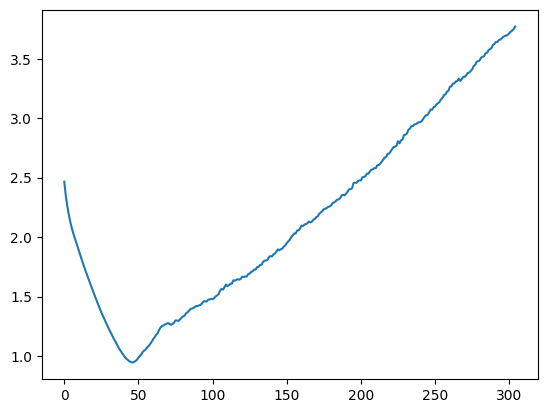

In [ ]:
import json
f = open('/content/drive/MyDrive/running_dir_mnist/numberDIR_tl_va_e095.json')
data = json.load(f)
#l=data['training loss list']
y081 = np.array(data['training loss list'])
plt.plot(y081)
plt.show()

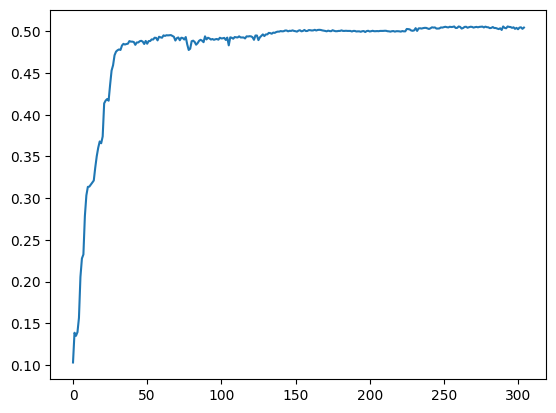

In [ ]:
y082 = np.array(data['valation accuracy list'])
plt.plot(y082)
plt.show()

In [ ]:
torch.save(att_net.state_dict(),'/content/drive/MyDrive/Colab_Notebooks/dir0123causl.pt')
torch.save(g.state_dict(),'/content/drive/MyDrive/Colab_Notebooks/dir0123pred.pt')

In [ ]:
new=[]
for i in range(len(l)):
  new.append(float(l[i]))
line=np.array(new)
plt.plot(line)
plt.show()

NameError: ignored

In [ ]:
t2=DataLoader(training_final[20000:], batch_size=1, shuffle=False)
t2_load=[]
for i in t2:
  t2_load.append(i)

In [ ]:
len(t2_load)

In [ ]:
causal_acc=0
conf_acc=0
n_test_data=0
for graph in t2_load:
  graph.to(device)
  n_test_data+=1


  (causal_x, causal_edge_index, causal_edge_attr, causal_edge_weight, causal_batch),\
  (conf_x, conf_edge_index, conf_edge_attr, conf_edge_weight, conf_batch), edge_score = att_net(graph)

  set_masks(causal_edge_weight, g)
  causal_out = g(
      x=causal_x, edge_index=causal_edge_index,
      edge_attr=causal_edge_attr, batch=causal_batch)
  set_masks(conf_edge_weight, g)
  conf_out = g(x=conf_x, edge_index=conf_edge_index,
          edge_attr=conf_edge_attr, batch=conf_batch)
  clear_masks(g)
  causal_acc += torch.sum(causal_out.argmax(-1).view(-1) == graph.y.view(-1))
  conf_acc += torch.sum(conf_out.argmax(-1).view(-1) == graph.y.view(-1))



In [ ]:
causal_acc/4754

In [ ]:
#newdata_with_feat_knn=[]
for i in range(len(data_with_feat_knn.labels)):
  if(data_with_feat_knn[i][1]==0):
    sp_data=data_with_feat_knn.sp_data[i]
    adj_matrix=data_with_feat_knn.Adj_matrices[i]
    label=data_with_feat_knn[i][1]
    feat_coord=data_with_feat_knn.use_feat_for_graph
    break


In [ ]:
sp_data[1].shape

In [ ]:

t1=DataLoader(new_012, batch_size=1, shuffle=False)
t_load=[]
for i in t1:
  t_load.append(i)

In [ ]:
idex=0
(causal_x, causal_edge_index, causal_edge_attr, causal_edge_weight, causal_batch),\
      (conf_x, conf_edge_index, conf_edge_attr, conf_edge_weight, conf_batch), edge_score = att_net(t_load[idex].to(device))

In [ ]:
t_load[0]

In [ ]:
causal_node=np.array(torch.unique(causal_edge_index).cpu())
print(causal_node)

In [ ]:
causal_node=np.array(torch.unique(causal_edge_index).cpu())
print(causal_node)

In [ ]:
ncausal_node=np.array(torch.unique(conf_edge_index).cpu())
print(ncausal_node)

In [ ]:
conf_x.detach().numpy().sum(axis=1)

In [ ]:
plt.imshow(training_data_01[idex])
print("Label: ",training_label_01[idex])

In [ ]:
sample = np.random.choice(len(data_with_feat_knn))
g_sample = data_with_feat_knn[idex][0]
print("Label: ", data_with_feat_knn[idex][1])
nx.draw(g_sample.to_networkx(), with_labels=True)
plt.show()

In [ ]:
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from pylab import rcParams
def plot_superpixels_graph(sp_data, adj_matrix, label, feat_coord, with_edges,real,conf_x):
    Y = squareform(pdist(sp_data[1], 'euclidean'))
    x_coord = sp_data[1] #np.flip(dataset.train.sp_data[_][1], 1)
    #intensities = sp_data[0].mean(axis=1)
    #label = classes[label]
    if real:
      intensities = sp_data[0].mean(axis=1)
    else:
      intensities=np.array([0]*sp_data[0].shape[0])
      intensities[ncausal_node]=conf_x.detach().numpy()
      #intensities=np.array(conf_x.sum(dim=1).cpu().detach())




    G = nx.from_numpy_array(Y)
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
    rotated_pos = {node: (y,-x) for (node, (x,y)) in pos.items()} # rotate the coords by 90 degree

    edge_list = []
    for src, dsts in enumerate(compute_edges_list(adj_matrix)[0]):
        for dst in dsts:
            edge_list.append((src, dst))

    nx.draw_networkx_nodes(G, rotated_pos, node_color=intensities, cmap=matplotlib.cm.Reds, node_size=60) #len(intensities))
    if with_edges:
        nx.draw_networkx_edges(G, rotated_pos, edge_list, alpha=0.3)




In [ ]:

#sp_data=data_with_feat_knn.sp_data[idex]
#adj_matrix=data_with_feat_knn.Adj_matrices[idex]
#label=data_with_feat_knn[idex][1]
#feat_coord=data_with_feat_knn.use_feat_for_graph
Y = squareform(pdist(sp_data[1], 'euclidean'))
x_coord = sp_data[1] #np.flip(dataset.train.sp_data[_][1], 1)
#intensities = sp_data[0].mean(axis=1)
#label = classes[label]


intensities=np.array([0]*sp_data[0].shape[0])
intensities[causal_node]=causal_x.detach().numpy().sum(axis=1)
  #intensities=np.array(conf_x.sum(dim=1).cpu().detach())




G = nx.from_numpy_array(Y)
pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
rotated_pos = {node: (y,-x) for (node, (x,y)) in pos.items()} # rotate the coords by 90 degree

edge_list = []
for src, dsts in enumerate(compute_edges_list(adj_matrix)[0]):
    for dst in dsts:
        edge_list.append((src, dst))

nx.draw_networkx_nodes(G, rotated_pos, node_color=intensities, cmap=matplotlib.cm.Reds, node_size=60) #len(intensities))
if True:
    nx.draw_networkx_edges(G, rotated_pos, edge_list, alpha=0.3)
#with_edges=True
#plt.figure(figsize=(5, 5))
#real=False
#plot_superpixels_graph(sp_data, adj_matrix, label, feat_coord, with_edges,real,conf_x)

In [ ]:
plt.figure(figsize=(5, 5))
real=True
plot_superpixels_graph(sp_data, adj_matrix, label, feat_coord, with_edges,real,causal_node)